In [1]:
!pip install transformers sentencepiece

In [1]:
import sentencepiece

In [2]:
import ast
import copy
import gc
import itertools
import joblib
import json
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import scipy as sp
import string
import sys
import time
import warnings


from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoConfig, AutoModel

# ======= OPTIONS =========
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device is: {device}")
warnings.filterwarnings("ignore")

Current device is: cuda


In [3]:
class config:
    APEX = True # Automatic Precision Enabled
    BATCH_SCHEDULER = True
    BATCH_SIZE_TRAIN = 32
    BATCH_SIZE_VALID = 16
    BETAS = (0.9, 0.999)
    DEBUG = False
    DECODER_LR = 2e-5
    ENCODER_LR = 2e-5
    EPOCHS = 5
    EPS = 1e-6
    FOLDS = 4
    GRADIENT_ACCUMULATION_STEPS = 1
    GRADIENT_CHECKPOINTING = True
    MAX_GRAD_NORM=1000
    MAX_LEN = 512
    MIN_LR = 1e-6
    MODEL = "microsoft/deberta-v3-base"
    NUM_CYCLES = 0.5
    NUM_WARMUP_STEPS = 0
    NUM_WORKERS = multiprocessing.cpu_count()
    PRINT_FREQ = 20
    SCHEDULER = 'cosine' # ['linear', 'cosine']
    SEED = 27
    TRAIN = True
    TRAIN_FOLDS = [0, 1, 2, 3]
    WANDB = False
    WEIGHT_DECAY = 0.01

class paths:
    OUTPUT_PATH = "./model/BERT"

if config.DEBUG:
    config.EPOCHS = 2
    config.TRAIN_FOLDS = [0]

In [4]:
os.chdir('..')
os.getcwd()

'/home/kvats/private/nw/ECE-143-Final-Project'

In [5]:
def get_config_dict(config):
    """
    Return the config, which is originally a class, as a Python dictionary.
    """
    config_dict = dict((key, value) for key, value in config.__dict__.items() 
    if not callable(value) and not key.startswith('__'))
    return config_dict


def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
    ]
    return optimizer_parameters


def get_logger(filename):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.SCHEDULER == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps
        )
    elif cfg.SCHEDULER == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.NUM_WARMUP_STEPS,
            num_training_steps=num_train_steps, num_cycles=cfg.NUM_CYCLES
        )
    return scheduler
    

def get_score(y_trues, y_preds):
    score = roc_auc_score(y_trues, y_preds)
    return score


def seed_everything(seed=20):
    """Seed everything to ensure reproducibility"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

def sep():
    print("-"*100)
    
    
def sigmoid(x):
    return 1 / (1 + np.exp(-x))  
    
LOGGER = get_logger("./model/BERT")
seed_everything(seed=config.SEED)

In [6]:
def dataset_split(path='raw/',ratio=(0.7,0.15,0.15))->pd.DataFrame:
    """split raw csv files into train, validation and test sets

    Args:
        path (str, optional): path of raw files. Defaults to '../raw/'.
        ratio (tuple, optional): splitting ratio. Defaults to (0.7,0.15,0.15).

    Returns:
        pd.DataFrame: train, validation and test sets
    """    
    assert sum(ratio)==1.0 and len(ratio)==3, "ratio error"
    true_df = pd.read_csv(path+'Fake.csv')
    fake_df = pd.read_csv(path+'True.csv')
    true_df["label"] = 1
    fake_df["label"] = 0
    df = pd.concat([true_df, fake_df], ignore_index=True)
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    train_df, temp_df = train_test_split(df, test_size=ratio[2]+ratio[1], random_state=42, stratify=df["label"])
    val_df, test_df = train_test_split(temp_df, test_size=ratio[2]/(ratio[2]+ratio[1]), random_state=42, stratify=temp_df["label"])
    return train_df,val_df,test_df

In [7]:
train_df, val_df, test_df = train_df, val_df, test_df = dataset_split(ratio=(0.8, 0.1, 0.1))

In [8]:
from sklearn.model_selection import StratifiedKFold
train_df = train_df.reset_index(drop=True)

skf = StratifiedKFold(n_splits=5)
X = train_df.loc[:, train_df.columns != "label"]
y = train_df.loc[:, train_df.columns == "label"]

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    train_df.loc[valid_index, "fold"] = i
    
print(train_df.groupby("fold")["label"].value_counts())
train_df.head()

fold  label
0.0   1        2792
      0        2587
1.0   1        2791
      0        2587
2.0   1        2791
      0        2587
3.0   1        2791
      0        2587
4.0   1        2791
      0        2587
Name: count, dtype: int64


,title,text,subject,date,label,fold
0,Clinton opposition to Asia trade pact 'close c...,Anyone with any sense of history realizes that...,politicsNews,"October 11, 2016",0,0.0
1,A MUST READ: OBAMA’S TREASON GOES INTO OVERDRIVE,Our culture is what makes this Nation great an...,politics,"Apr 6, 2015",1,0.0
2,"Probe of Clinton's email driven by facts, not ...",It s no secret that Senator John McCain hates ...,politicsNews,"June 30, 2016",0,0.0
3,Scott Baio Tries To Push Hillary’s ‘Body Doubl...,"Yesterday, Democratic nominee Hillary Clinton ...",News,"September 12, 2016",1,0.0
4,Alec Baldwin Just Put Trump’s Idiot Supporters...,Saturday Night Live returned with a stellar co...,News,"April 9, 2017",1,0.0


In [9]:
tokenizer = AutoTokenizer.from_pretrained(config.MODEL)
tokenizer.save_pretrained(paths.OUTPUT_DIR + '/tokenizer/')
print(tokenizer)

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-base', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}


  0%|          | 0/26891 [00:00<?, ?it/s]

max_len: 512


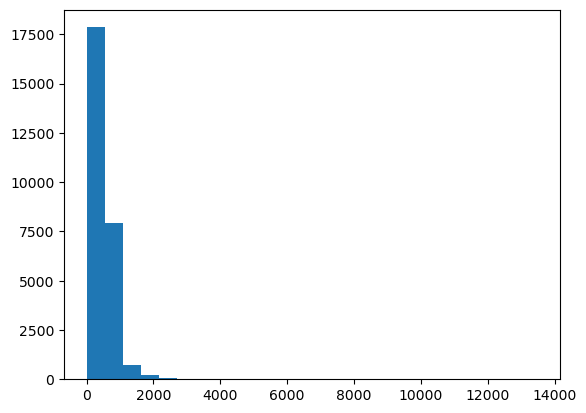

In [10]:
lengths = []
tqdm_loader = tqdm(train_df['text'].fillna("").values, total=len(train_df))
for text in tqdm_loader:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
    
# config.MAX_LEN = max(lengths) + 3 # cls & sep & sep
LOGGER.info(f"max_len: {config.MAX_LEN}")
_ = plt.hist(lengths, bins=25)

In [11]:
def prepare_input(cfg, text, tokenizer):
    """
    This function tokenizes the input text with the configured padding and truncation. Then,
    returns the input dictionary, which contains the following keys: "input_ids",
    "token_type_ids" and "attention_mask". Each value is a torch.tensor.
    :param cfg: configuration class with a TOKENIZER attribute.
    :param text: a numpy array where each value is a text as string.
    :return inputs: python dictionary where values are torch tensors.
    """
    inputs = tokenizer.encode_plus(
        text, 
        return_tensors=None, 
        add_special_tokens=True, 
        max_length=cfg.MAX_LEN,
        padding='max_length', # TODO: check padding to max sequence in batch
        truncation=True
    )
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long) # TODO: check dtypes
    return inputs


def collate(inputs):
    """
    It truncates the inputs to the maximum sequence length in the batch. 
    """
    mask_len = int(inputs["attention_mask"].sum(axis=1).max()) # Get batch's max sequence length
    for k, v in inputs.items():
        inputs[k] = inputs[k][:,:mask_len]
    return inputs


class CustomDataset(Dataset):
    def __init__(self, cfg, df, tokenizer):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['label'].values
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        output = {}
        output["inputs"] = prepare_input(self.cfg, self.texts[item], self.tokenizer)
        output["labels"] = torch.tensor(self.labels[item], dtype=torch.float) # TODO: check dtypes
        return output

In [12]:
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings
    

class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.dropout = 0.2
        # Load config by inferencing it from the model name.
        if config_path is None: 
            self.config = AutoConfig.from_pretrained(cfg.MODEL, output_hidden_states=True)
            self.config.hidden_dropout = 0.
            self.config.hidden_dropout_prob = 0.
            self.config.attention_dropout = 0.
            self.config.attention_probs_dropout_prob = 0.
        # Load config from a file.
        else:
            self.config = torch.load(config_path)
        
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.MODEL, config=self.config)
        else:
            self.model = AutoModel(self.config)
        
        if self.cfg.GRADIENT_CHECKPOINTING:
            self.model.gradient_checkpointing_enable()
          
        # Add MeanPooling and Linear head at the end to transform the Model into a RegressionModel
        self.pool = MeanPooling()
        self.head = nn.Sequential(
            nn.Linear(self.config.hidden_size, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(64, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(16, 1)
        )
        self._init_weights(self.head)
        
    def _init_weights(self, module):
        """
        This method initializes weights for different types of layers. The type of layers 
        supported are nn.Linear, nn.Embedding and nn.LayerNorm.
        """
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        """
        This method makes a forward pass through the model, get the last hidden state (embedding)
        and pass it through the MeanPooling layer.
        """
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        feature = self.pool(last_hidden_states, inputs['attention_mask'])
        return feature

    def forward(self, inputs):
        """
        This method makes a forward pass through the model, the MeanPooling layer and finally
        then through the Linear layer to get a regression value.
        """
        feature = self.feature(inputs)
        output = self.head(feature)
        return output

In [20]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    """One epoch training pass."""
    model.train() # set model in train mode
    scaler = torch.cuda.amp.GradScaler(enabled=config.APEX) # Automatic Mixed Precision tries to match each op to its appropriate datatype.
    losses = AverageMeter() # initiate AverageMeter to track the loss.
    start = end = time.time() # track the execution time.
    global_step = 0
    
    # ========== ITERATE OVER TRAIN BATCHES ============
    with tqdm(train_loader, unit="train_batch", desc='Train') as tqdm_train_loader:
        for step, batch in enumerate(tqdm_train_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items(): # send each tensor value to `device`
                inputs[k] = v.to(device)
            labels = labels.to(device) # send labels to `device`
            batch_size = labels.size(0)
            with torch.cuda.amp.autocast(enabled=config.APEX):
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels.unsqueeze(1)) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            scaler.scale(loss).backward() # backward propagation pass
            grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)

            if (step + 1) % config.GRADIENT_ACCUMULATION_STEPS == 0:
                scaler.step(optimizer) # update optimizer parameters
                scaler.update()
                optimizer.zero_grad() # zero out the gradients
                global_step += 1
                if config.BATCH_SCHEDULER:
                    scheduler.step() # update learning rate
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(train_loader)-1):
                print('Epoch: [{0}][{1}/{2}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      'Grad: {grad_norm:.4f}  '
                      'LR: {lr:.8f}  '
                      .format(epoch+1, step, len(train_loader), 
                              remain=timeSince(start, float(step+1)/len(train_loader)),
                              loss=losses,
                              grad_norm=grad_norm,
                              lr=scheduler.get_lr()[0]))
            if config.WANDB:
                wandb.log({f"[fold_{fold}] train loss": losses.val,
                           f"[fold_{fold}] lr": scheduler.get_lr()[0]})

    return losses.avg


def valid_epoch(valid_loader, model, criterion, device):
    model.eval() # set model in evaluation mode
    losses = AverageMeter() # initiate AverageMeter for tracking the loss.
    prediction_dict = {}
    preds = []
    start = end = time.time() # track the execution time.
    with tqdm(valid_loader, unit="valid_batch", desc='Validation') as tqdm_valid_loader:
        for step, batch in enumerate(tqdm_valid_loader):
            inputs = batch.pop("inputs")
            labels = batch.pop("labels")
            inputs = collate(inputs) # collate inputs
            for k, v in inputs.items():
                inputs[k] = v.to(device) # send inputs to device
            labels = labels.to(device)
            batch_size = labels.size(0)
            ids = torch.arange(start=step * batch_size, end=(step + 1) * batch_size).to(device)
            with torch.no_grad():
                y_preds = model(inputs) # forward propagation pass
                loss = criterion(y_preds, labels.unsqueeze(1)) # get loss
            if config.GRADIENT_ACCUMULATION_STEPS > 1:
                loss = loss / config.GRADIENT_ACCUMULATION_STEPS
            losses.update(loss.item(), batch_size) # update loss function tracking
            preds.append(y_preds.to('cpu').numpy()) # save predictions
            end = time.time() # get finish time

            # ========== LOG INFO ==========
            if step % config.PRINT_FREQ == 0 or step == (len(valid_loader)-1):
                print('EVAL: [{0}/{1}] '
                      'Elapsed {remain:s} '
                      'Loss: {loss.avg:.4f} '
                      .format(step, len(valid_loader),
                              loss=losses,
                              remain=timeSince(start, float(step+1)/len(valid_loader))))
            if config.WANDB:
                wandb.log({f"[fold_{fold}] val loss": losses.val})
                
    prediction_dict["predictions"] = np.concatenate(preds) # np.array() of shape (fold_size, target_cols)
    prediction_dict["ids"] = ids.cpu().numpy()
    return losses.avg, prediction_dict

In [21]:
def train_loop(folds, fold):
    
    LOGGER.info(f"========== Fold: {fold} training ==========")

    # ======== SPLIT ==========
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)

    valid_labels = valid_folds['label'].values

    # ======== DATASETS ==========
    train_dataset = CustomDataset(config, train_folds, tokenizer)
    valid_dataset = CustomDataset(config, valid_folds, tokenizer)
    
    # ======== DATALOADERS ==========
    train_loader = DataLoader(train_dataset,
                              batch_size=config.BATCH_SIZE_TRAIN, # TODO: split into train and valid
                              shuffle=True,
                              pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=config.BATCH_SIZE_VALID,
                              shuffle=False,
                              pin_memory=True, drop_last=False)
    
    # ======== MODEL ==========
    model = CustomModel(config, config_path=None, pretrained=True)
    torch.save(model.config, paths.OUTPUT_DIR + '/config.pth')
    model.to(device)

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=config.ENCODER_LR, 
                                                decoder_lr=config.DECODER_LR,
                                                weight_decay=config.WEIGHT_DECAY)
    optimizer = AdamW(optimizer_parameters,
                      lr=config.ENCODER_LR,
                      eps=config.EPS,
                      betas=config.BETAS)
    
    scheduler = OneCycleLR(
        optimizer,
        max_lr=1e-5,
        epochs=config.EPOCHS,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy="cos",
        final_div_factor=100,
    )

    # ======= LOSS ==========
    criterion = nn.BCEWithLogitsLoss()
    
    best_score = -np.inf
    # ====== ITERATE EPOCHS ========
    for epoch in range(config.EPOCHS):

        start_time = time.time()

        # ======= TRAIN ==========
        avg_loss = train_epoch(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # ======= EVALUATION ==========
        avg_val_loss, prediction_dict = valid_epoch(valid_loader, model, criterion, device)
        predictions = prediction_dict["predictions"]
        # ======= SCORING ==========
        score = get_score(valid_labels, sigmoid(predictions))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if config.WANDB:
            wandb.log({f"[fold_{fold}] epoch": epoch+1, 
                       f"[fold_{fold}] avg_train_loss": avg_loss, 
                       f"[fold_{fold}] avg_val_loss": avg_val_loss,
                       f"[fold_{fold}] score": score})
            
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save(model.state_dict(),
                        paths.OUTPUT_DIR + f"/{config.MODEL.replace('/', '_')}_fold_{fold}_best.pth")
            best_model_predictions = predictions

    valid_folds["preds"] = best_model_predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [22]:
if __name__ == '__main__':
    def get_result(oof_df):
        labels = oof_df["label"].values
        preds = oof_df["preds"].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if config.TRAIN:
        oof_df = pd.DataFrame()
        for fold in range(config.FOLDS):
            if fold == 0:
                _oof_df = train_loop(train_df, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== Fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_csv(paths.OUTPUT_DIR + '/oof_df.csv', index=False)

========== Fold: 0 training ==========


Train:   0%|          | 0/672 [00:00<?, ?train_batch/s]

Epoch: [1][0/672] Elapsed 0m 1s (remain 12m 2s) Loss: 0.7137 Grad: 215192.5000  LR: 0.00000040  
Epoch: [1][20/672] Elapsed 0m 21s (remain 11m 19s) Loss: 0.7278 Grad: 236519.7500  LR: 0.00000049  
Epoch: [1][40/672] Elapsed 0m 42s (remain 10m 58s) Loss: 0.7211 Grad: 318569.7500  LR: 0.00000075  
Epoch: [1][60/672] Elapsed 1m 3s (remain 10m 37s) Loss: 0.7182 Grad: 219659.6250  LR: 0.00000116  
Epoch: [1][80/672] Elapsed 1m 24s (remain 10m 17s) Loss: 0.7153 Grad: 249998.7656  LR: 0.00000172  
Epoch: [1][100/672] Elapsed 1m 45s (remain 9m 56s) Loss: 0.7155 Grad: 226267.7500  LR: 0.00000240  
Epoch: [1][120/672] Elapsed 2m 6s (remain 9m 35s) Loss: 0.7155 Grad: 282572.0000  LR: 0.00000317  
Epoch: [1][140/672] Elapsed 2m 27s (remain 9m 15s) Loss: 0.7167 Grad: 218325.3125  LR: 0.00000402  
Epoch: [1][160/672] Elapsed 2m 48s (remain 8m 55s) Loss: 0.7153 Grad: 228138.8438  LR: 0.00000491  
Epoch: [1][180/672] Elapsed 3m 10s (remain 8m 35s) Loss: 0.7164 Grad: 226217.2188  LR: 0.00000581  
Epoch

KeyboardInterrupt: 

In [15]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
oof_df["preds"] = oof_df["preds"].apply(lambda x: sigmoid(x))
oof_df

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix

def binarize(x, threshold):
    if x > threshold:
        x = 1
    else:
        x = 0
    return x

# Assuming df is your pandas DataFrame
oof_df["binary"] = oof_df["preds"].apply(lambda x: binarize(x, 0.5))
true_labels = oof_df["label"].values
predicted_labels = oof_df["binary"].values

# Get the unique classes from both true and predicted labels
classes = np.unique(np.concatenate((true_labels, predicted_labels)))

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")